## * Solution for Overfitting 
 - L2 Regularization : parameter 의 크기가 발산하지 않도록 항 추가
 - Dropout : general 한 예측, 각각의 뉴런을 더 효율적으로 활용

## * Solution for Gradient Vanishing
  - ReLU Activation function
   

## * Other Techniques
  - Xavier Initialization : weight 초기화
  - Batch Normalization

## * Hyperparameter

### Using Argparse

In [60]:
import argparse

In [61]:
parser = argparse.ArgumentParser()
args = parser.parse_args("")

In [62]:
args.num_layer = 5
print(args.num_layer)
print(args)

args.in_dim = 100
print(args)

linears = []
for i in range(args.num_layer):
    linears.append(i)

print(linears)

d = vars(args) # convert to dict
print(d, type(d))

5
Namespace(num_layer=5)
Namespace(num_layer=5, in_dim=100)
[0, 1, 2, 3, 4]
{'num_layer': 5, 'in_dim': 100} <class 'dict'>


### Hyperparameter Tuning

* Model Related (MLP) : number of hidden layer, number of hidden unit, activation function
* Optimization Related : Type of Optimizer, Learning rate, L2 coef, Dropout Rate, Batch Size, Epoch-Early Stopping

-> 5 way to tune experiment : Grid Layout, Random Layout, Hand Tuning, Bayesian Optimization / AutoML

# Data Preparation

https://tutorials.pytorch.kr/beginner/blitz/cifar10_tutorial.html

In [63]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import argparse
import numpy as np

In [64]:

transform = transforms.Compose(
    [transforms.ToTensor(), # image to tensor
     transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))]) # normalize (mean, std) for each channel

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainset, valset = torch.utils.data.random_split(trainset, [40000, 10000]) # validation set 만들기
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                        shuffle=False)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


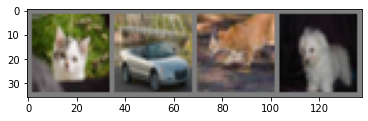

cat   car   cat   dog  


In [65]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = next(dataiter)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

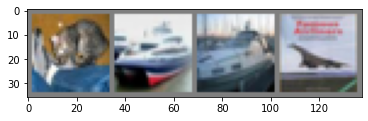

GroundTruth:  cat   ship  ship  plane


In [78]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# 테스트 이미지 출력
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [66]:
# 타입, 차원 확인
print(type(images), images.shape) # 첫 번째 element는 batch_size와 동일, 두 번째 element는 RGB

print(type(labels), labels.shape, labels) # 첫 번째 element는 batch_size와 동일

<class 'torch.Tensor'> torch.Size([4, 3, 32, 32])
<class 'torch.Tensor'> torch.Size([4]) tensor([3, 1, 3, 5])


# Model Architecture

In [67]:
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act):
        super(MLP, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act

        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)
        self.linears = nn.ModuleList()
        for i in range(n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)

        if self.act == 'relu':
            self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.fc1(x))
        for fc in self.linears:
            x = self.act(fc(x))
        x = self.fc2(x)
        return x

In [68]:
model = MLP (in_dim=3*32*32, out_dim=10, hid_dim=100, n_layer=5, act='relu')
print(model) # 정의한 순서대로 보여줌

MLP(
  (fc1): Linear(in_features=3072, out_features=100, bias=True)
  (linears): ModuleList(
    (0-3): 4 x Linear(in_features=100, out_features=100, bias=True)
  )
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (act): ReLU()
)


# Define Experiment

In [69]:
def experiment(args):
    net= MLP(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act)
    net.cuda()
    # print(net)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=args.lr, momentum=args.mm)

    for epoch in range(args.epoch):

        #======= Train =======#
        net.train()

        running_loss = 0.0 # mini-batch 당 loss
        train_loss = 0.0 # 한 epoch 당 loss

        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs = inputs.view(-1, 3072)

            inputs = inputs.cuda()
            labels = labels.cuda()

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            train_loss += loss.item()
            if i%2000 == 1999: # print every 2000 mini-batches
                print('[%d, %5d] loss: %.3f' 
                      %(epoch+1, i+1, running_loss/2000))
                running_loss = 0.0
    
        print('Finished {} Training'.format(epoch+1))

        #======= Validation =======#
        net.eval()

        correct = 0
        total = 0
        val_loss = 0.0
        # 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                images = images.view(-1, 3072)

                images = images.cuda()
                labels = labels.cuda()

                # 신경망에 이미지를 통과시켜 출력을 계산합니다
                outputs = net(images)

                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            val_loss = val_loss / len(valloader)
            val_acc = 100 * correct / total

        # epoch마다 loss 출력
        print('Epoch {}, Train Loss: {:2.2f}, Val Loss: {:2.2f}, Val Acc: {:2.2f}%'.format(epoch+1, train_loss, val_loss, val_acc)) 

    #======= Evaluation =======#
    net.eval() # model을 다 train 한 후 testset에 대한 evaluation을 진행

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.view(-1, 3072)

            images = images.cuda()
            labels = labels.cuda()

            outputs = net(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted==labels).sum().item()

        test_acc = 100 * correct / total

    return train_loss, val_loss, val_acc, test_acc

# Experiment

In [71]:
# random seed 고정
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)

In [77]:
# hyperparameter 세팅
import argparse
parser = argparse.ArgumentParser()
args = parser.parse_args("")

# model-related parameters
args.n_layer = 5
args.in_dim = 3072 #3*32*32
args.out_dim = 10
args.hid_dim = 100
args.act = 'relu'

# optimization-related parameters
args.lr = 0.001
args.mm = 0.9
args.epoch = 2

In [73]:
result = experiment(args)
print('Experiment : Train Loss: {:2.2f}, Val Loss: {:2.2f}, Val Acc: {:2.2f}%, Test Acc: {:2.2f}%'.format(*result)) 

[1,  2000] loss: 2.297
[1,  4000] loss: 2.108
[1,  6000] loss: 1.943
[1,  8000] loss: 1.798
[1, 10000] loss: 1.706
Finished 1 Training
Epoch 1, Train Loss: 19702.70, Val Loss: 1.69, Val Acc: 38.72%
[2,  2000] loss: 1.663
[2,  4000] loss: 1.618
[2,  6000] loss: 1.606
[2,  8000] loss: 1.573
[2, 10000] loss: 1.573
Finished 2 Training
Epoch 2, Train Loss: 16066.06, Val Loss: 1.54, Val Acc: 45.47%
Experiment : Train Loss: 16066.06, Val Loss: 1.54, Val Acc: 45.47%, Test Acc: 45.25%


### Hyperparameter search

In [75]:
list_var1 = [4, 5, 6]
list_var2 = [50, 100, 150]

count = 0
for var1 in list_var1:
    for var2 in list_var2:
        count += 1
        args.n_layer = var1
        args.hid_dim = var2
        result = experiment(args)
        print('Experiment {}: Train Loss: {:2.2f}, Val Loss: {:2.2f}, Val Acc: {:2.2f}%, Test Acc: {:2.2f}%'.format(count, *result))  